In [1]:
### Simulation parameters
n_donors = 2
n_conditions = 3
n_cells_per_donor_cond = 300
n_clones_in_don = 5
n_positions = 100
n_variants_per_clone_lambda = 1
n_donor_variants = 10

seq_error = 0.01
don_var_lim=(0.8,1)
clone_var_lim=(0.1,0.4)
depth_lim = (4,10)
chars = ["A", "G", "C", "T"]


ref_fa = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"
dirs = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/Control/MT/cellr_True/numread_200/"

pileups_indir = "/data/Mito_Trace/output/clone_pileups_simulation/"
predict_indir =  "/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/knn/kparam_30/"

outdir =  "/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_mgatkdonor/knn/kparam_30/pred_vs_known/"
to_test = False



In [2]:
from Bio import SeqIO

import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join, exists
import os
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline
import mplh.cluster_help as ch

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16)



fig_utils from mplh
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
params = {"donors":n_donors,"conditions":n_conditions, "cells_per_donor_cond":n_cells_per_donor_cond,
         "clones_in_don":n_clones_in_don, "positions":n_positions, 
          "variants_per_clone_lambda":n_variants_per_clone_lambda, "donor_variants":n_donor_variants}


seq_params = {"seq_error": seq_error, "don_var_lim":"_".join(np.array(don_var_lim).astype(str)), 
              "clone_var_lim": "_".join(np.array(clone_var_lim).astype(str)),
             "depth_lim":"_".join(np.array(depth_lim).astype(str))}

curr_out_meta = ""
for p in params:
    curr_out_meta = f"{curr_out_meta}__{p}_{params[p]}"

curr_out_meta = curr_out_meta.strip("__")
print(curr_out_meta)


curr_out_seq = ""
for p in seq_params:
    curr_out_seq = f"{curr_out_seq}__{p}_{seq_params[p]}"
curr_out_seq = curr_out_seq.strip("__")
print(curr_out_seq)


curr_pileups_indir = join(pileups_indir, curr_out_meta, curr_out_seq)



donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10
seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10


## Load data

In [4]:
#ref_char = np.random.choice(chars, n_positions)
ref_char = list(str(SeqIO.to_dict(SeqIO.parse(ref_fa, "fasta"))["chrM"].seq))

ref = [f"{i}_{c}" for i, c in enumerate(ref_char)]

ref_df = pd.DataFrame(np.array([range(len(ref_char)),ref_char]).transpose(),index=ref, columns=["pos", "ref"])
ref_df.head()

,pos,ref
0_G,0,G
1_A,1,A
2_T,2,T
3_C,3,C
4_A,4,A


In [5]:
don_vars_df = pd.read_csv(join(curr_pileups_indir, "donor_vars.csv"), index_col=0)
clone_vars_df = pd.read_csv(join(curr_pileups_indir, "clone_vars.csv"), index_col=0)
all_cells_df = pd.read_csv(join(curr_pileups_indir, "cells_meta.csv"), index_col=0)
clones_meta_cond_df = pd.read_csv(join(curr_pileups_indir, "clones_meta.csv"), index_col=0)

In [6]:
clone_vars_df["id"] = clone_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
don_vars_df["id"] = don_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
vars_of_interest = pd.concat([clone_vars_df.set_index("id"),don_vars_df.set_index("id")], axis=0)
vars_of_interest = vars_of_interest[["donor", "clone"]]
vars_of_interest

,donor,clone
id,,
7369>T,0,d0cl0
6842>A,0,d0cl0
7151>T,0,d0cl1
15306>G,0,d0cl1
4225>C,0,d0cl2
2841>C,0,d0cl2
5663>G,0,d0cl2
2549>A,0,d0cl3
1972>G,0,d0cl3


## Load in results cells_meta and preprocess

In [7]:
predict_cells_meta = pd.read_csv(join(predict_indir, "cells_meta.tsv"), sep="\t", index_col=0)
predict_cells_meta.index = [x.split("_")[0] for x in predict_cells_meta.index]
predict_cells_meta = predict_cells_meta.rename({"lineage":"clone"}, axis=1)
predict_cells_meta = predict_cells_meta.fillna("-")
predict_cells_meta["donor"] = predict_cells_meta["donor"].astype(str).fillna("-")
predict_cells_meta["clone"] = predict_cells_meta["clone"].astype(str).fillna("-")

predict_cells_meta["clone"] = predict_cells_meta["donor"] + "_" + predict_cells_meta["clone"]
predict_cells_meta.head()

,clone,donor,condition
Cell103donor0condition2cloned0cl3,0_0,0,cond2
Cell105donor0condition2cloned0cl3,0_0,0,cond2
Cell107donor0condition1cloned0cl3,0_0,0,cond1
Cell109donor0condition1cloned0cl3,0_0,0,cond1
Cell113donor0condition1cloned0cl3,0_0,0,cond1


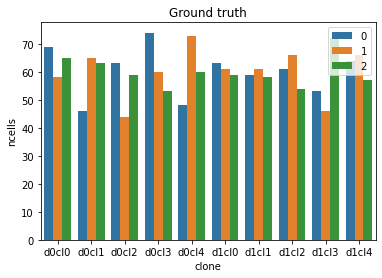

In [8]:
sns.barplot(data=clones_meta_cond_df,x="clone", y="ncells", hue="condition")
plt.legend(loc='best')
plt.title("Ground truth")
plt.savefig(join(outdir, "barplot_known_clone_sizes.png"))

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


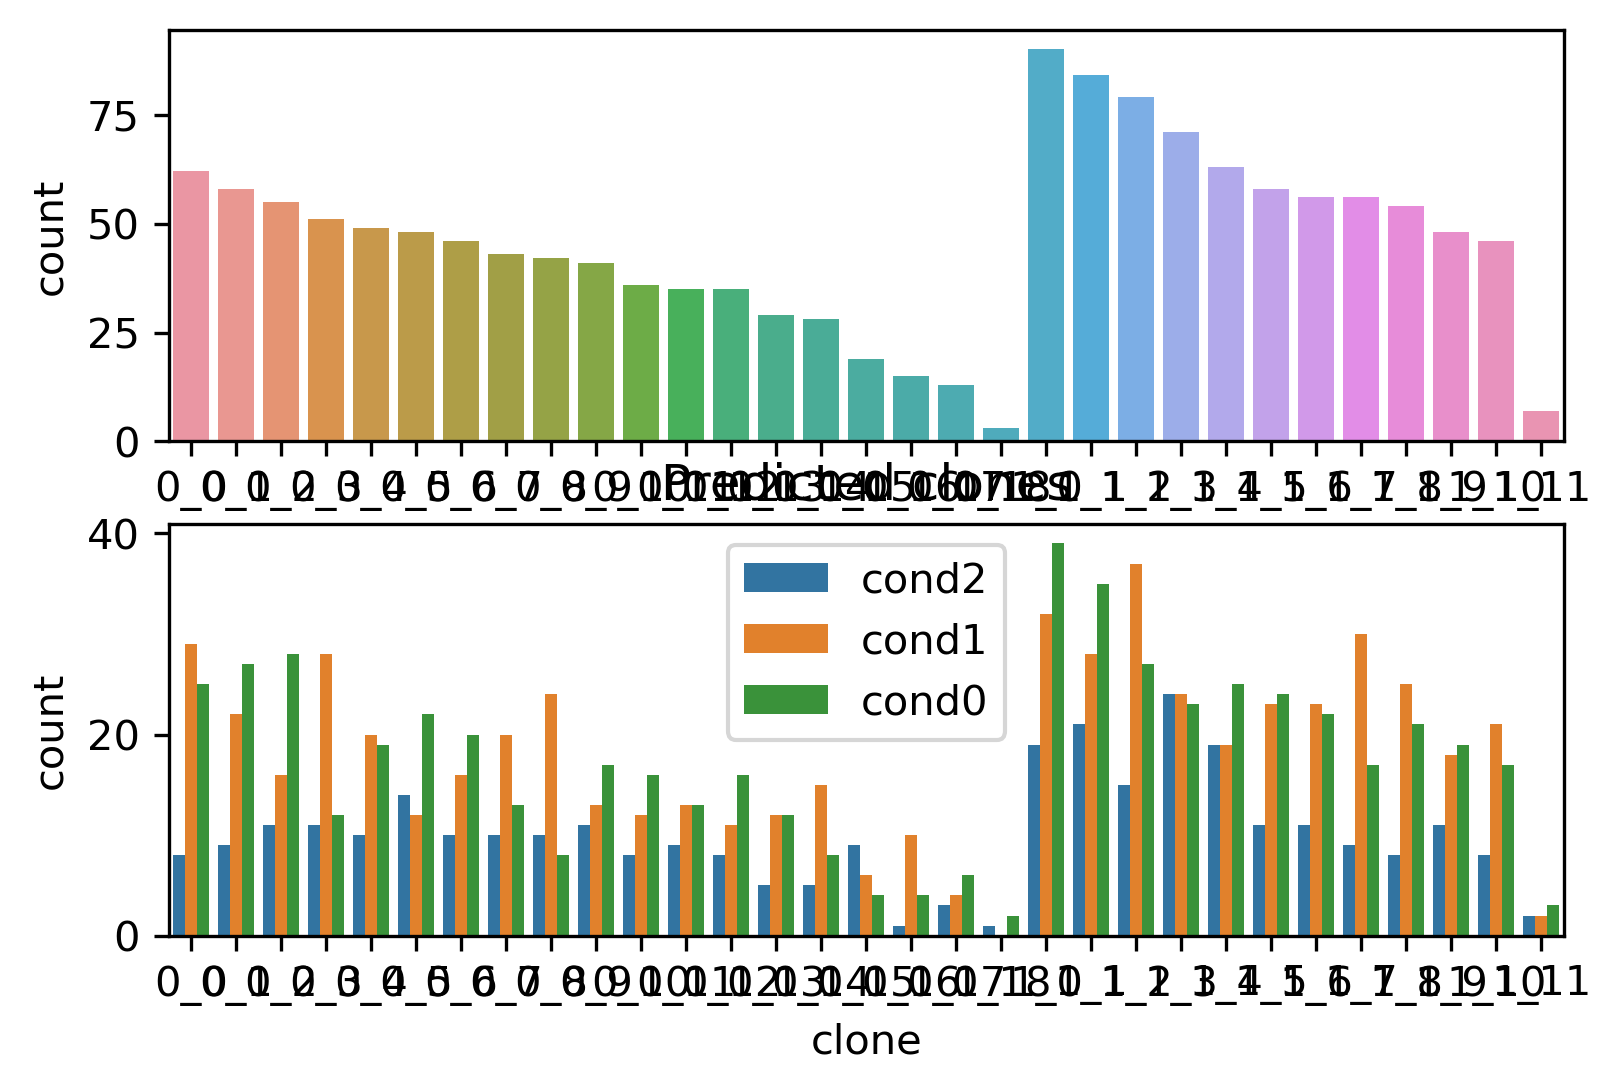

In [9]:
f, ax = plt.subplots(nrows=2, dpi=300)
sns.countplot(predict_cells_meta["clone"], ax=ax[0])
plt.title("Predicted clones")

sns.countplot(data=predict_cells_meta, x="clone", hue='condition', ax=ax[1])
plt.legend(loc='best')
plt.title("Predicted clones")
plt.savefig(join(outdir, "barplot_pred_clone_sizes.png"))

# Compare cell assignments

### 2 ways to do this. 
### a) We don't know which donor in gold standard corresponds to the other. We can groupby and match them if 50% agree
### b) We do cell-cell pairwise comparisons, so for each cell-cell pair we see if it a) Same group and agrees w gold standard (gs) (TP), Same group and disagrees (FP), Different group and agrees with gs (TN), different group and disagrees with gs (FN)

In [10]:
gold_pred_df = pd.merge(all_cells_df, predict_cells_meta, left_index=True, right_index=True, 
                        suffixes=("_groundTruth", "_predicted"))
gold_pred_df

,donor_groundTruth,condition_groundTruth,clone_groundTruth,clone_predicted,donor_predicted,condition_predicted
Cell0donor0condition0cloned0cl3,0,0,d0cl3,0_11,0,cond0
Cell1donor0condition0cloned0cl4,0,0,d0cl4,0_17,0,cond0
Cell2donor0condition0cloned0cl2,0,0,d0cl2,0_6,0,cond0
Cell3donor0condition0cloned0cl4,0,0,d0cl4,0_14,0,cond0
Cell4donor0condition0cloned0cl4,0,0,d0cl4,0_13,0,cond0
...,...,...,...,...,...,...
Cell281donor1condition2cloned1cl3,1,2,d1cl3,1_3,1,cond2
Cell289donor1condition2cloned1cl3,1,2,d1cl3,1_4,1,cond2
Cell290donor1condition2cloned1cl1,1,2,d1cl1,1_1,1,cond2
Cell291donor1condition2cloned1cl4,1,2,d1cl4,1_9,1,cond2


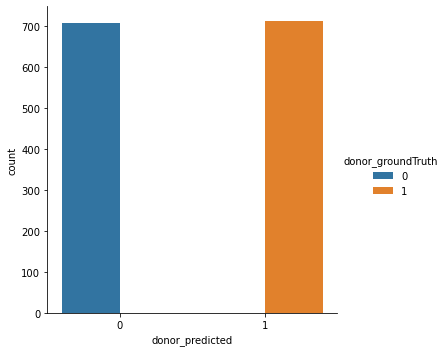

In [11]:
g = sns.catplot(x="donor_predicted", hue="donor_groundTruth", 
                data=gold_pred_df, kind="count")
plt.savefig(join(outdir, "barplot_donors_pred_known.png"))

In [12]:
gold_pred_df.head()

,donor_groundTruth,condition_groundTruth,clone_groundTruth,clone_predicted,donor_predicted,condition_predicted
Cell0donor0condition0cloned0cl3,0,0,d0cl3,0_11,0,cond0
Cell1donor0condition0cloned0cl4,0,0,d0cl4,0_17,0,cond0
Cell2donor0condition0cloned0cl2,0,0,d0cl2,0_6,0,cond0
Cell3donor0condition0cloned0cl4,0,0,d0cl4,0_14,0,cond0
Cell4donor0condition0cloned0cl4,0,0,d0cl4,0_13,0,cond0


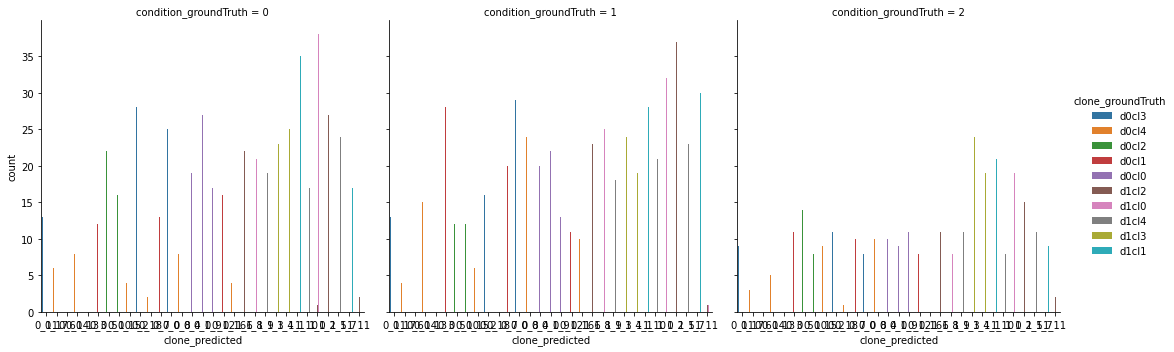

In [13]:
g = sns.catplot(x="clone_predicted", col="condition_groundTruth",hue="clone_groundTruth", 
                data=gold_pred_df, kind="count")
plt.savefig(join(outdir, "barplot_pred_known.png"))

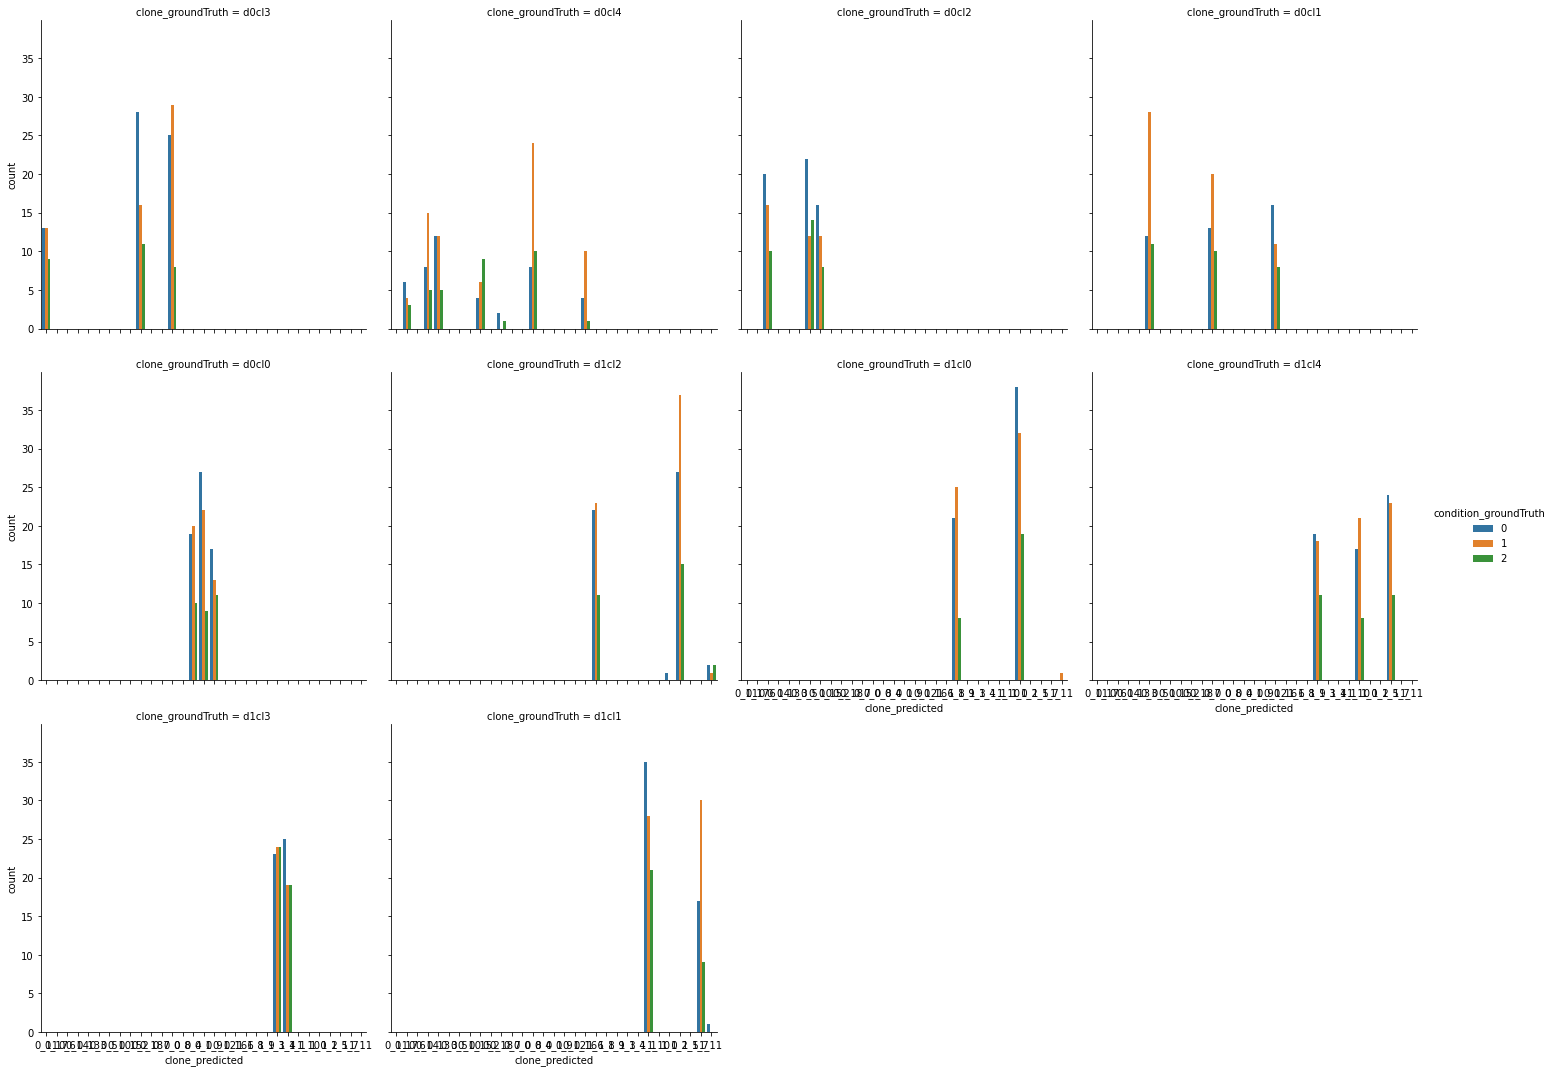

In [14]:
g = sns.catplot(x="clone_predicted", col="clone_groundTruth",hue="condition_groundTruth", col_wrap=4,
                data=gold_pred_df, kind="count")
plt.savefig(join(outdir, "barplot_conditions_pred_known.png"))


## They seem to be assigned to only one clone, which is nice

## Assign each pred clone to the gs clone it's seen the most in

In [15]:
groups = gold_pred_df.groupby(["clone_predicted", "clone_groundTruth"]).size().reset_index()
#groups

## Test the groupby function
a) add more of diff clones
b) Make two of the same numbers the same, in same pred clones and in different

In [16]:
if to_test:
    groups = groups.append(pd.Series({"clone_predicted":"1_2", "clone_groundTruth": "d1cl3", 0: 20 }), ignore_index=True)
    groups = groups.append(pd.Series({"clone_predicted":"1_2", "clone_groundTruth": "d1cl4", 0: 80 }),ignore_index=True)
    groups = groups.append(pd.Series({"clone_predicted":"1_2", "clone_groundTruth": "d1cl4", 0: 141 }),ignore_index=True)
    groups = groups.append(pd.Series({"clone_predicted":"1_3", "clone_groundTruth": "d1cl4", 0: 141 }),ignore_index=True)
    groups

In [17]:
idx = groups.groupby(['clone_predicted'])[0].transform(max) == groups[0]
idx
labels = groups[idx].set_index("clone_predicted")
labels = labels.loc[~(labels.index.duplicated(keep='first'))]
labels

,clone_groundTruth,0
clone_predicted,,
0_0,d0cl3,62
0_1,d0cl0,58
0_10,d0cl2,36
0_11,d0cl3,35
0_12,d0cl1,35
0_13,d0cl4,29
0_14,d0cl4,28
0_15,d0cl4,19
0_16,d0cl4,15


In [18]:
gold_pred_df["map_clone_predicted"] = gold_pred_df["clone_predicted"].map(labels["clone_groundTruth"])
gold_pred_df

,donor_groundTruth,condition_groundTruth,clone_groundTruth,clone_predicted,donor_predicted,condition_predicted,map_clone_predicted
Cell0donor0condition0cloned0cl3,0,0,d0cl3,0_11,0,cond0,d0cl3
Cell1donor0condition0cloned0cl4,0,0,d0cl4,0_17,0,cond0,d0cl4
Cell2donor0condition0cloned0cl2,0,0,d0cl2,0_6,0,cond0,d0cl2
Cell3donor0condition0cloned0cl4,0,0,d0cl4,0_14,0,cond0,d0cl4
Cell4donor0condition0cloned0cl4,0,0,d0cl4,0_13,0,cond0,d0cl4
...,...,...,...,...,...,...,...
Cell281donor1condition2cloned1cl3,1,2,d1cl3,1_3,1,cond2,d1cl3
Cell289donor1condition2cloned1cl3,1,2,d1cl3,1_4,1,cond2,d1cl3
Cell290donor1condition2cloned1cl1,1,2,d1cl1,1_1,1,cond2,d1cl1
Cell291donor1condition2cloned1cl4,1,2,d1cl4,1_9,1,cond2,d1cl4


## Calculate accuracy

In [19]:
pos = (gold_pred_df["map_clone_predicted"] == gold_pred_df["clone_groundTruth"]).sum()
tot = gold_pred_df.shape[0]
acc = pos/tot
print(f"accuracy: {acc}")

accuracy: 0.997887323943662


## Pair-pair calculations

## Variants of same position

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
from src.clones_compare import clones_compare as cc
def wrap_calc_cell_pairs(all_methods_df):
    all_methods_pairs_df = {}

    cell_pairs_df = pd.DataFrame(index=gold_pred_df.index,
                                 columns=gold_pred_df.index)
    all_methods_pairs_df["ground"] = cell_pairs_df.apply(cc.calc_cell_pairs, args=(gold_pred_df["clone_groundTruth"],), axis=1)
    cell_pairs_df = pd.DataFrame(index=gold_pred_df.index,
                             columns=gold_pred_df.index)
    all_methods_pairs_df["pred"] = cell_pairs_df.apply(cc.calc_cell_pairs, args=(gold_pred_df["clone_predicted"],), axis=1)

    return all_methods_pairs_df

In [22]:
all_methods_pairs_df = wrap_calc_cell_pairs(gold_pred_df)

curr_id Cell0donor0condition0cloned0cl3
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl3
here
curr_id Cell1donor0condition0cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl4
here
curr_id Cell2donor0condition0cloned0cl2
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl2
here
curr_id Cell3donor0condition0cloned0cl4


curr_id Cell177donor0condition0cloned0cl0
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl0
here
curr_id Cell178donor0condition0cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl4
here
curr_id Cell179donor0condition0cloned0cl0
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl0
here
curr_id Cell181donor0condition0clo

curr_id Cell294donor0condition0cloned0cl3
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl3
here
curr_id Cell295donor0condition0cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl4
here
curr_id Cell296donor0condition0cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl4
here
curr_id Cell297donor0condition0clo

curr_id Cell255donor0condition1cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl4
here
curr_id Cell256donor0condition1cloned0cl2
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl2
here
curr_id Cell257donor0condition1cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl4
here
curr_id Cell258donor0condition1clo

curr_id Cell135donor0condition2cloned0cl1
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl1
here
curr_id Cell137donor0condition2cloned0cl3
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl3
here
curr_id Cell139donor0condition2cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d0cl4
here
curr_id Cell140donor0condition2clo

curr_id Cell197donor1condition0cloned1cl0
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d1cl0
here
curr_id Cell198donor1condition0cloned1cl3
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d1cl3
here
curr_id Cell199donor1condition0cloned1cl1
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d1cl1
here
curr_id Cell200donor1condition0clo

curr_id Cell291donor1condition0cloned1cl0
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d1cl0
here
curr_id Cell292donor1condition0cloned1cl4
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d1cl4
here
curr_id Cell293donor1condition0cloned1cl1
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d1cl1
here
curr_id Cell294donor1condition0clo

curr_id Cell40donor1condition2cloned1cl1
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d1cl1
here
curr_id Cell43donor1condition2cloned1cl2
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d1cl2
here
curr_id Cell45donor1condition2cloned1cl0
clones_series Cell0donor0condition0cloned0cl3    d0cl3
Cell1donor0condition0cloned0cl4    d0cl4
Cell2donor0condition0cloned0cl2    d0cl2
Cell3donor0condition0cloned0cl4    d0cl4
Cell4donor0condition0cloned0cl4    d0cl4
Name: clone_groundTruth, dtype: object
curr_clone d1cl0
here
curr_id Cell46donor1condition2cloned1

curr_id Cell0donor0condition0cloned0cl3
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_11
here
curr_id Cell1donor0condition0cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_17
here
curr_id Cell2donor0condition0cloned0cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_6
here
curr_id Cell3donor0condition0cloned0cl4
clones_series Cell0donor0

curr_id Cell122donor0condition0cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_14
here
curr_id Cell123donor0condition0cloned0cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_5
here
curr_id Cell124donor0condition0cloned0cl0
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_4
here
curr_id Cell125donor0condition0cloned0cl3
clones_series Cell

curr_id Cell225donor0condition0cloned0cl0
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_4
here
curr_id Cell226donor0condition0cloned0cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_3
here
curr_id Cell227donor0condition0cloned0cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_12
here
curr_id Cell228donor0condition0cloned0cl2
clones_series Cell

curr_id Cell47donor0condition1cloned0cl0
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_9
here
curr_id Cell48donor0condition1cloned0cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_3
here
curr_id Cell49donor0condition1cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_15
here
curr_id Cell50donor0condition1cloned0cl1
clones_series Cell0don

curr_id Cell154donor0condition1cloned0cl3
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_2
here
curr_id Cell155donor0condition1cloned0cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_7
here
curr_id Cell156donor0condition1cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_13
here
curr_id Cell157donor0condition1cloned0cl2
clones_series Cell

curr_id Cell261donor0condition1cloned0cl0
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_9
here
curr_id Cell262donor0condition1cloned0cl4
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_17
here
curr_id Cell263donor0condition1cloned0cl3
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_11
here
curr_id Cell264donor0condition1cloned0cl3
clones_series Cel

curr_id Cell116donor0condition2cloned0cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_12
here
curr_id Cell117donor0condition2cloned0cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_7
here
curr_id Cell125donor0condition2cloned0cl0
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 0_1
here
curr_id Cell126donor0condition2cloned0cl3
clones_series Cell

curr_id Cell10donor1condition0cloned1cl3
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_4
here
curr_id Cell11donor1condition0cloned1cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_2
here
curr_id Cell12donor1condition0cloned1cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_6
here
curr_id Cell13donor1condition0cloned1cl0
clones_series Cell0dono

curr_id Cell132donor1condition0cloned1cl0
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_0
here
curr_id Cell133donor1condition0cloned1cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_2
here
curr_id Cell134donor1condition0cloned1cl3
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_3
here
curr_id Cell135donor1condition0cloned1cl0
clones_series Cell0

curr_id Cell251donor1condition0cloned1cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_1
here
curr_id Cell252donor1condition0cloned1cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_6
here
curr_id Cell253donor1condition0cloned1cl0
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_0
here
curr_id Cell254donor1condition0cloned1cl1
clones_series Cell0

curr_id Cell60donor1condition1cloned1cl4
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_10
here
curr_id Cell61donor1condition1cloned1cl0
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_0
here
curr_id Cell62donor1condition1cloned1cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_7
here
curr_id Cell63donor1condition1cloned1cl0
clones_series Cell0don

curr_id Cell182donor1condition1cloned1cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_7
here
curr_id Cell183donor1condition1cloned1cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_2
here
curr_id Cell184donor1condition1cloned1cl4
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_9
here
curr_id Cell185donor1condition1cloned1cl4
clones_series Cell0

curr_id Cell289donor1condition1cloned1cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_6
here
curr_id Cell290donor1condition1cloned1cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_2
here
curr_id Cell291donor1condition1cloned1cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_1
here
curr_id Cell292donor1condition1cloned1cl0
clones_series Cell0

curr_id Cell177donor1condition2cloned1cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_1
here
curr_id Cell178donor1condition2cloned1cl1
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_7
here
curr_id Cell179donor1condition2cloned1cl2
clones_series Cell0donor0condition0cloned0cl3    0_11
Cell1donor0condition0cloned0cl4    0_17
Cell2donor0condition0cloned0cl2     0_6
Cell3donor0condition0cloned0cl4    0_14
Cell4donor0condition0cloned0cl4    0_13
Name: clone_predicted, dtype: object
curr_clone 1_6
here
curr_id Cell181donor1condition2cloned1cl0
clones_series Cell0

In [23]:
all_methods_pairs_df.keys()

dict_keys(['ground', 'pred'])

In [24]:
all_methods_pairs_df["ground"].iloc[:10,:10]

,Cell0donor0condition0cloned0cl3,Cell1donor0condition0cloned0cl4,Cell2donor0condition0cloned0cl2,Cell3donor0condition0cloned0cl4,Cell4donor0condition0cloned0cl4,Cell5donor0condition0cloned0cl1,Cell6donor0condition0cloned0cl2,Cell7donor0condition0cloned0cl2,Cell8donor0condition0cloned0cl2,Cell9donor0condition0cloned0cl4
Cell0donor0condition0cloned0cl3,True,False,False,False,False,False,False,False,False,False
Cell1donor0condition0cloned0cl4,False,True,False,True,True,False,False,False,False,True
Cell2donor0condition0cloned0cl2,False,False,True,False,False,False,True,True,True,False
Cell3donor0condition0cloned0cl4,False,True,False,True,True,False,False,False,False,True
Cell4donor0condition0cloned0cl4,False,True,False,True,True,False,False,False,False,True
Cell5donor0condition0cloned0cl1,False,False,False,False,False,True,False,False,False,False
Cell6donor0condition0cloned0cl2,False,False,True,False,False,False,True,True,True,False
Cell7donor0condition0cloned0cl2,False,False,True,False,False,False,True,True,True,False
Cell8donor0condition0cloned0cl2,False,False,True,False,False,False,True,True,True,False
Cell9donor0condition0cloned0cl4,False,True,False,True,True,False,False,False,False,True


In [25]:
compare_df = cc.calc_meth_overlap(all_methods_pairs_df["ground"], all_methods_pairs_df["pred"])
compare_df

{'n_T_T': 78312,
 'n_F_F': 1813892,
 'n_F_T': 200,
 'n_T_F': 123996,
 'n_T_T_norm': 0.3870929473871523,
 'n_F_F_norm': 0.9998897520081672,
 'n_F_T_norm': 0.00011024799183282876,
 'n_T_F_norm': 0.6129070526128477,
 'n_nas_mone': 0,
 'n_nas_mtwo': 0,
 'n_nas_both': 0,
 'n_nas_mis': 0,
 'n_together': 2016400,
 'n_agree': 1892204}

In [26]:
meth_df = pd.DataFrame(columns=["m1", "m2", "n_agree", "n_T_T", "n_F_F", "n_F_T", "n_T_F", 
                                "n_T_T_norm", "n_F_F_norm", 
                                "n_F_T_norm", "n_T_F_norm", "n_nas_mone", "n_nas_mtwo", 
                                "n_nas_both", "n_nas_mis", "n_together"])

#curr_d_methods = list(all_methods_pairs_df.keys())
#curr_d_pairs = list(itertools.product(curr_d_methods, repeat=2))
curr_pair = ["ground", "pred"]

a = all_methods_pairs_df[curr_pair[0]]
b = all_methods_pairs_df[curr_pair[1]]
curr_out = cc.calc_meth_overlap(a,b)
curr_out["m1"] = curr_pair[0]
curr_out["m2"] = curr_pair[1]
meth_df = meth_df.append(pd.DataFrame(curr_out, index= [f"m1{curr_pair[0]}_m2{curr_pair[1]}"]))
meth_df["n_agree_norm"] = meth_df["n_agree"]/meth_df["n_together"]
meth_df

,m1,m2,n_agree,n_T_T,n_F_F,n_F_T,n_T_F,n_T_T_norm,n_F_F_norm,n_F_T_norm,n_T_F_norm,n_nas_mone,n_nas_mtwo,n_nas_both,n_nas_mis,n_together,n_agree_norm
m1ground_m2pred,ground,pred,1892204,78312,1813892,200,123996,0.387093,0.99989,0.00011,0.612907,0,0,0,0,2016400,0.938407


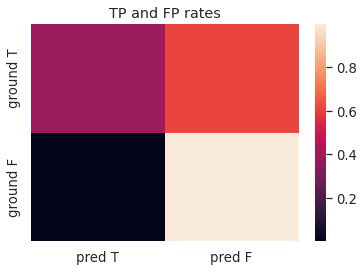

In [27]:
df = pd.DataFrame(index=["ground T","ground F"], columns=["pred T","pred F"],
             data=[[meth_df.iloc[0]["n_T_T_norm"], meth_df.iloc[0]["n_T_F_norm"]],
                   [meth_df.iloc[0]["n_F_T_norm"], meth_df.iloc[0]["n_F_F_norm"]]])
sns.heatmap(df)

plt.title("TP and FP rates")
plt.savefig(join(outdir, "norm_confusion.png"))
df.to_csv(join(outdir, "norm_confusion.csv"))

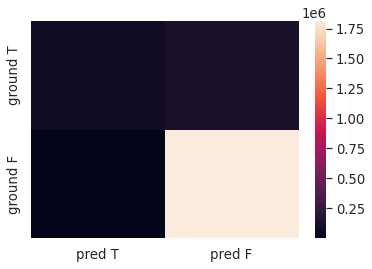

In [28]:
df = pd.DataFrame(index=["ground T","ground F"], columns=["pred T","pred F"],
             data=[[meth_df.iloc[0]["n_T_T"], meth_df.iloc[0]["n_T_F"]],
                   [meth_df.iloc[0]["n_F_T"], meth_df.iloc[0]["n_F_F"]]])
sns.heatmap(df)
plt.savefig(join(outdir, "n_confusion.png"))
df.to_csv(join(outdir, "n_confusion.csv"))

## Check the known variants.. including the ones with the same position